# Radioastronomia 1 2017/18
## Sprawozdanie - ćw. 2b
## Wyznaczenie poziomu i położenia listków bocznych charakterystyki kierunkowej anteny
### Dawid Kubicki

## Wstęp

Ćwiczenie przeprowadzono 20 października 2017 w Obserwatorium Astronomicznym UJ przy radioteleskopie RT-15. Jego celem było wyznaczenie listków bocznych charakterystyki kierunkowej anteny.

## Przebieg ćwiczenia

Na samym początku radioteleskop skierowany był na zenit. Dokonano kalibracji (z tłumieniem $10dB$), a następnie najechano anteną na okolice słońca według wyznaczonych wcześniej efemeryd. Niebo było całkowicie zachmurzone, jednakże dla długości fal na których wykonywano obserwacje ($21 cm$) nie było to przeszkodą. Pierwsze pomiary dokonano bez tłumienia. Dwukrotnie przejechano teleskopem przez słońce wzdłuż kąta godzinnego, a następnie dwukrotnie wzdłuż deklinacji. Wyniki zapisano w pliku RADIO15.DAT. 

Następnie ustawiono tłumienie radioteleskopu na $20dB$, a kalibratora na $0dB$, oraz przesunięto skalę przetwornika analogowo-cyfrowego. Przy próbie skanu słońca wyniki wykroczyły poza skalę. Zostały one zapisane w pliku LGLOWNY.DAT. 

Dokonano kolejnego przesunięcia skali przetwornika, ale znowu przekroczono dozwolony zakres. Po tej porażce zwiększono tłumienie do $30dB$ i dokonano czterokrotnie skanu w kącie godzinnym. 


## Opracowanie

Za pomocą programu OOD przeliczono dane z surowego pliku .DAT na deklinację i rektascensję. Jako że wykonanie ćwiczenia trwało około godzinę, to w tym czasie deklinację i rektascensję słońca można uznać za stałą, szczególnie że jej zmiana jest zdecydowanie mniejsza od dokładności ustawienia radioteleskopu.

Na początku przyjrzymy się danym z pierwszej części obserwacji - bez tłumienia. 

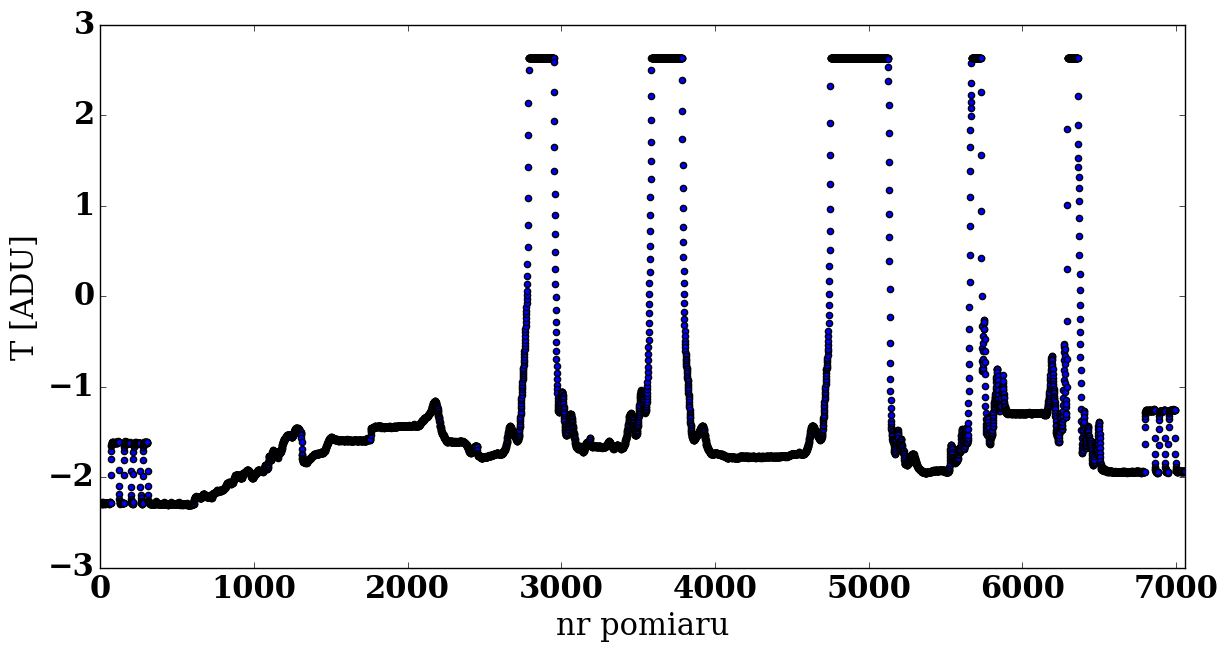

In [97]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

def load_data(filename):
    with open(filename) as f:
        res = []
        for line in f:
            res.append(line.split())
        return np.array(res).astype(np.float)
    
data = load_data('/home/dawid/radioastronomy/2b/RADIO15R.TXT')
data_count = len(data)
sig = [d[2] for d in data]
nr = np.arange(data_count)

plt.figure(figsize=(14, 7))
plt.scatter(nr, sig)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()    


Wyraźnie widać początkową i końcową kalibrację, najazd w okolice słońca, dwa skany w kącie godzinnym, ustawienie kąta godzinnego mniej więcej na środek słońca oraz dwa skany w deklinacji. 

Zaczniemy standardowo od skorzystania z kalibracji i wyliczenie odpowiedniego współczynnika. Następnie przyjrzymy się teraz jak wyglądała zmiana rektascensji i deklinacji obserwowanego punktu od czasu.

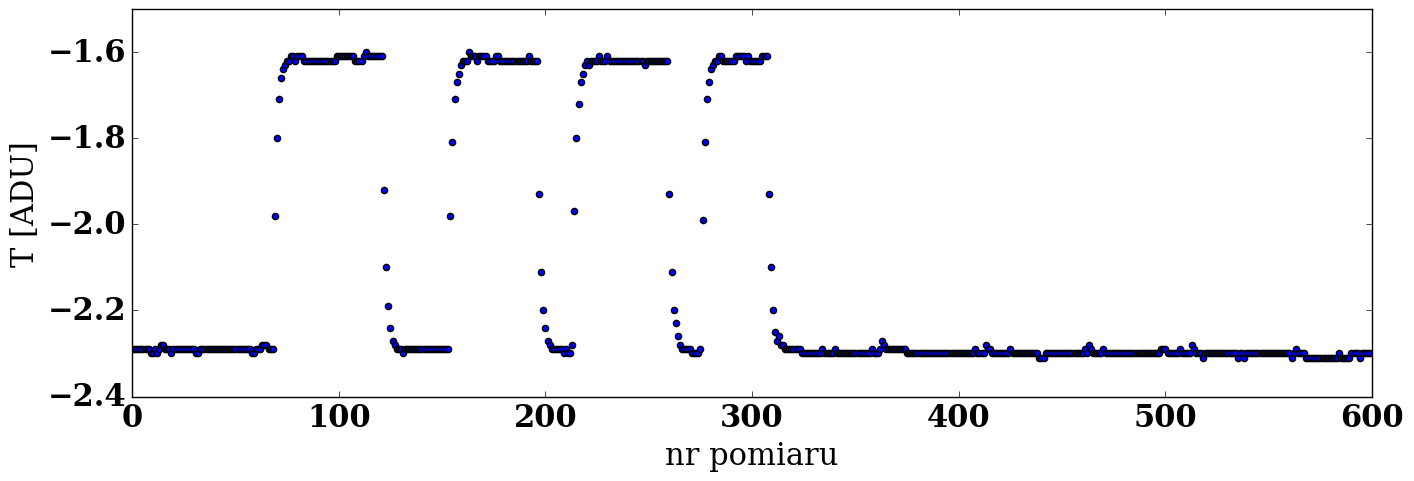

12.704148999 0.197481191785


In [98]:
cal_data = data[:600]
cal_sig_all = [float(d[2]) for d in cal_data]

plt.figure(figsize=(16, 5))
plt.scatter(nr[:600], cal_sig_all)
plt.xlim((0, 600))
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()   

cal_sig = np.concatenate([cal_sig_all[80:120], cal_sig_all[165:190], cal_sig_all[220:260]])
sys_sig = cal_sig_all[340:600]

t_cal = np.mean(cal_sig)
dt_cal = np.std(cal_sig)

t_sys = np.mean(sys_sig)
dt_sys = np.std(sys_sig)

#Z cwiczenia 1a
def a_i(t_cal, t_sys, t_i):
    return t_i * 8670 / (t_cal - t_sys)

def delta_a_i(t_cal, t_sys, dt_cal, dt_sys, t_i):
    return t_i * 8670 * ((dt_sys+dt_cal)/(t_cal - t_sys)/(t_cal - t_sys))

a = a_i(t_cal, t_sys, 0.001)
da = delta_a_i(t_cal, t_sys, dt_cal, dt_sys, 0.001)
print(a, da)

Otrzymujemy przelicznik $$a = 12.7 \pm 0.2 \frac{K}{ADU}$$

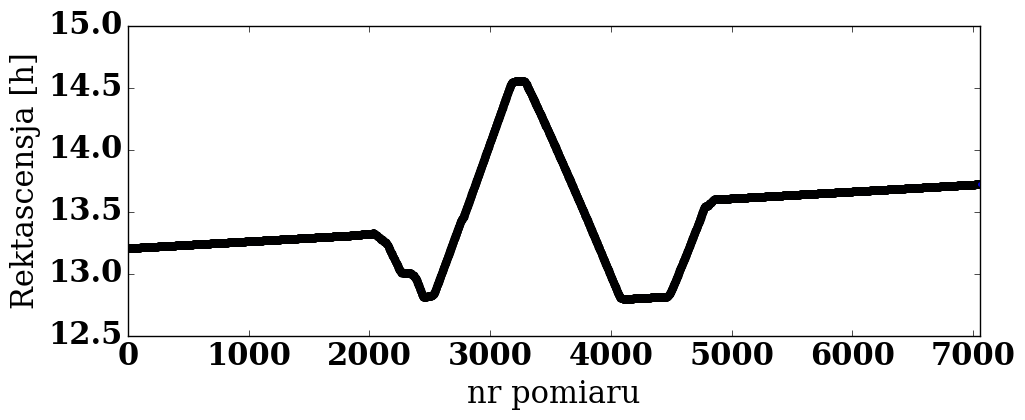

In [99]:
t = np.array([d[0] for d in data])

plt.figure(figsize=(11, 4))
plt.scatter(nr, t)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Rektascensja [h]")
plt.show()    

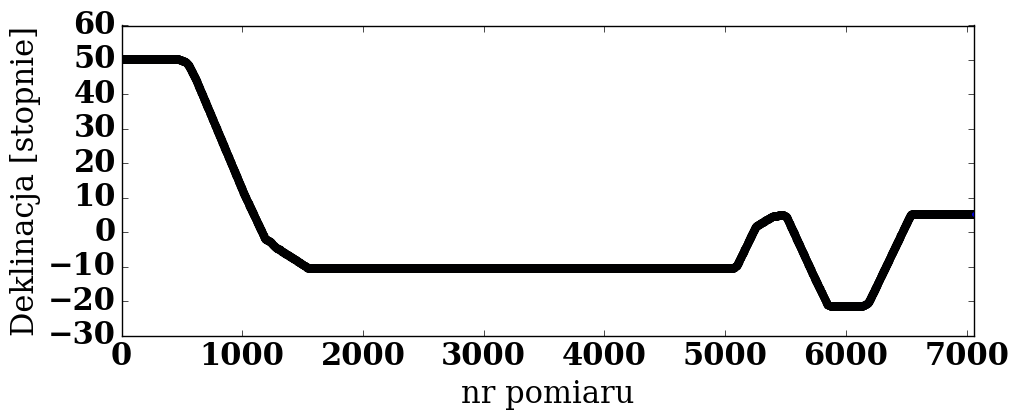

In [100]:
dec = np.array([float(d[1]) for d in data])

plt.figure(figsize=(11, 4))
plt.scatter(nr, dec)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Deklinacja [stopnie]")
plt.show()    

Wytnijmy sygnał dla skanów w kącie godzinnym i przedstawmy je na wykresie. 

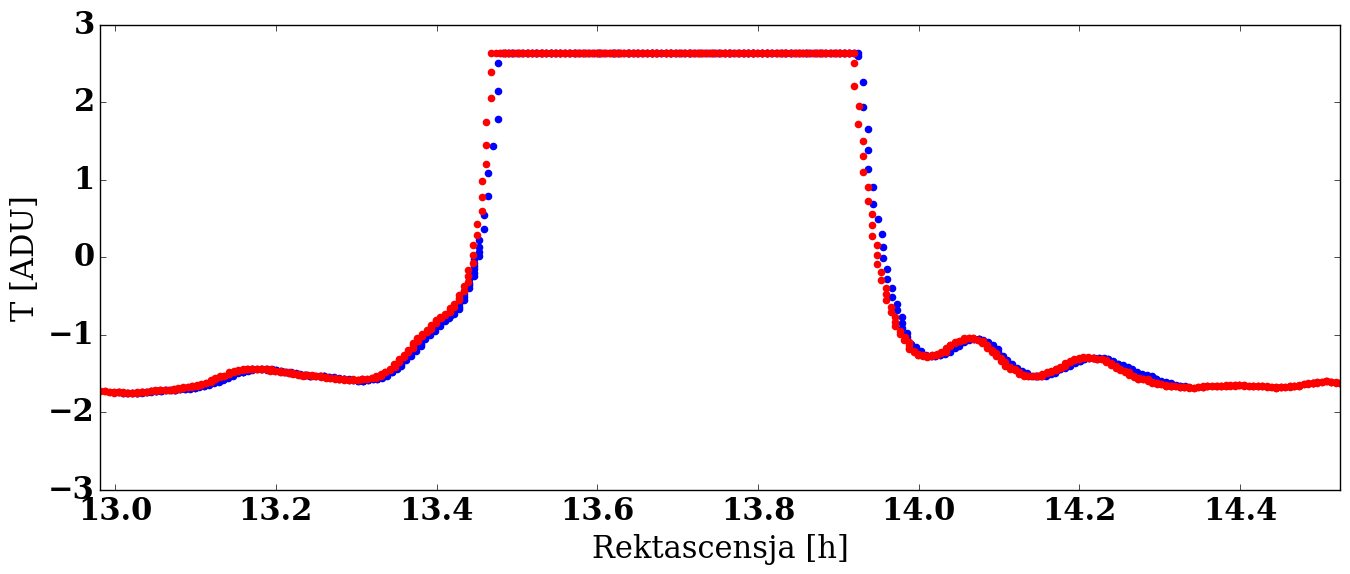

In [101]:
skant1 = data[2600:3100]
skant2 = data[3300:4000]

def plot_data_t(data, c = 'b'):
    sig = [d[2] for d in data]
    ra = [float(d[0]) for d in data]
    plt.scatter(ra, sig, s = 20, color=c)
    plt.xlim([np.min(ra), np.max(ra)])
    plt.xlabel("Rektascensja [h]")
    plt.ylabel("T [ADU]")
    
plt.figure(figsize=(16, 6))
plot_data_t(skant1, 'b')
plot_data_t(skant2, 'r')
plt.show()    


Widzimy, że krzywe z obu pomiarów są bardzo podobne, lecz lekko przesunięte. Wynika to prawdopodobnie z faktu, że skany wykonywano w dwie różne strony, a pomiar charakteryzuje się pewną inercją. Dzięki temu, że tak wykonaliśmy pomiary ich średnia powinna dać bardziej wiarygodny wynik.

Przy uśrednianiu pojawia się problem, że pomiary mają różne współrzędne, czasem różniące się o wielkości rzędu sekund, czyli bardzo niewiele przy dokładności RT-15. Aby móc sensownie uśrednić dane zastosujemy zaokrąglenie do połowy minuty.

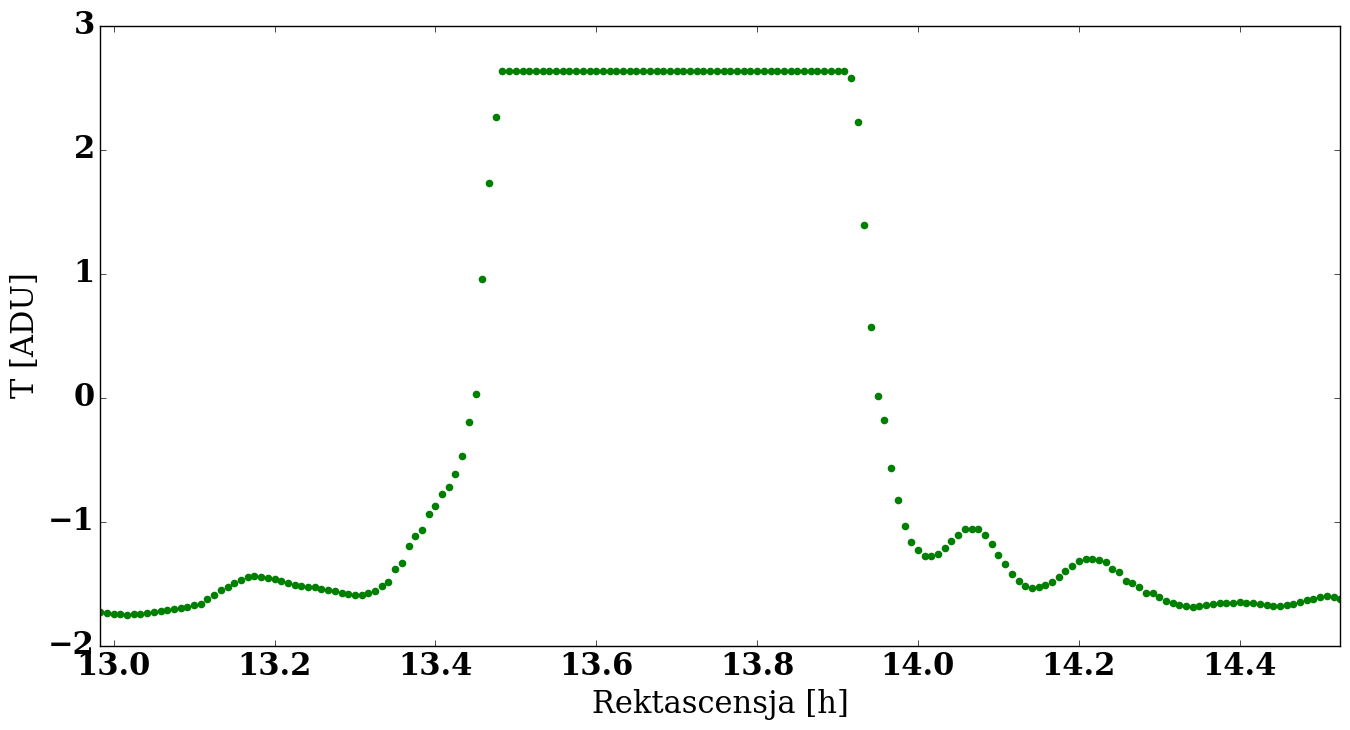

In [102]:
def round_ra(ra):
    hours = int(ra)
    minutes = int((ra - hours)*60)
    seconds = round((ra - hours - minutes/60.0)*3600)
    if seconds >= 60:
        minutes += 1
        seconds -= 60
    if minutes >= 60:
        hours += 1
        minutes -= 60
    if seconds >= 45:
        minutes += 1
    elif 15 <= seconds <= 45:
        minutes += 0.5
    return hours + minutes/60.0


def group_by_ra(data):
    res = dict()
    for d in data:
        ra = round_ra(float(d[0]))
        if ra not in res:
            res[ra] = [float(d[2])]
        else:
            res[ra].append(float(d[2]))
    return res

def calc_mean(data_dict):
    ra = []
    sig = []
    std = []
    for key in data_dict:
        ra.append(float(key))
        sig.append(np.mean(data_dict[key]))
        std.append(np.std(data_dict[key]))
    sorting_perm = np.argsort(ra)
    a1, a2, a3 = np.array(ra), np.array(sig), np.array(std)
    return a1[sorting_perm], a2[sorting_perm], a3[sorting_perm]

mean_ra, mean_sig, std = calc_mean(group_by_ra(np.concatenate([skant1, skant2])))

plt.figure(figsize=(16, 8))
plt.scatter(mean_ra, mean_sig, s = 20, color='g')
plt.xlim([np.min(mean_ra), np.max(mean_ra)])
plt.xlabel("Rektascensja [h]")
plt.ylabel("T [ADU]")
plt.show()    


Otrzymana krzywa jest wyraźnie niesymetryczna. Na prawo widać dwa listki boczne (i lekkie zafalowanie, które może być defektem danych, albo kolejnym bardzo słabym listkiem). Natomiast na lewo widać jednen listek boczny, dość płaski w porównaniu z tymi po prawej. Ponadto między $13.3^h$ a $13.4^h$ widać lekkie wybrzuszenie, które także może pochodzić od listka, bądź mieć inną przyczynę np. wynikać z natury źródła. 

Dopasujmy krzywe Gaussa do trzech wspomnianych listków. Próbujemy fitować funkcję daną wzorem
$$f(x) = a e^{\frac{(x-b)^2}{2\sigma^2}} + d$$

[  0.13324288  13.1866894    0.03918083  -1.58257779] [ 0.00850201  0.00192759  0.00344583  0.00808303]
[  0.5806834   14.06554373   0.03614031  -1.63196832] [ 0.03219448  0.0004573   0.00190133  0.03406656]
[  0.32954285  14.21488223   0.03675793  -1.62620168] [ 0.01970351  0.00052166  0.0021603   0.02107262]


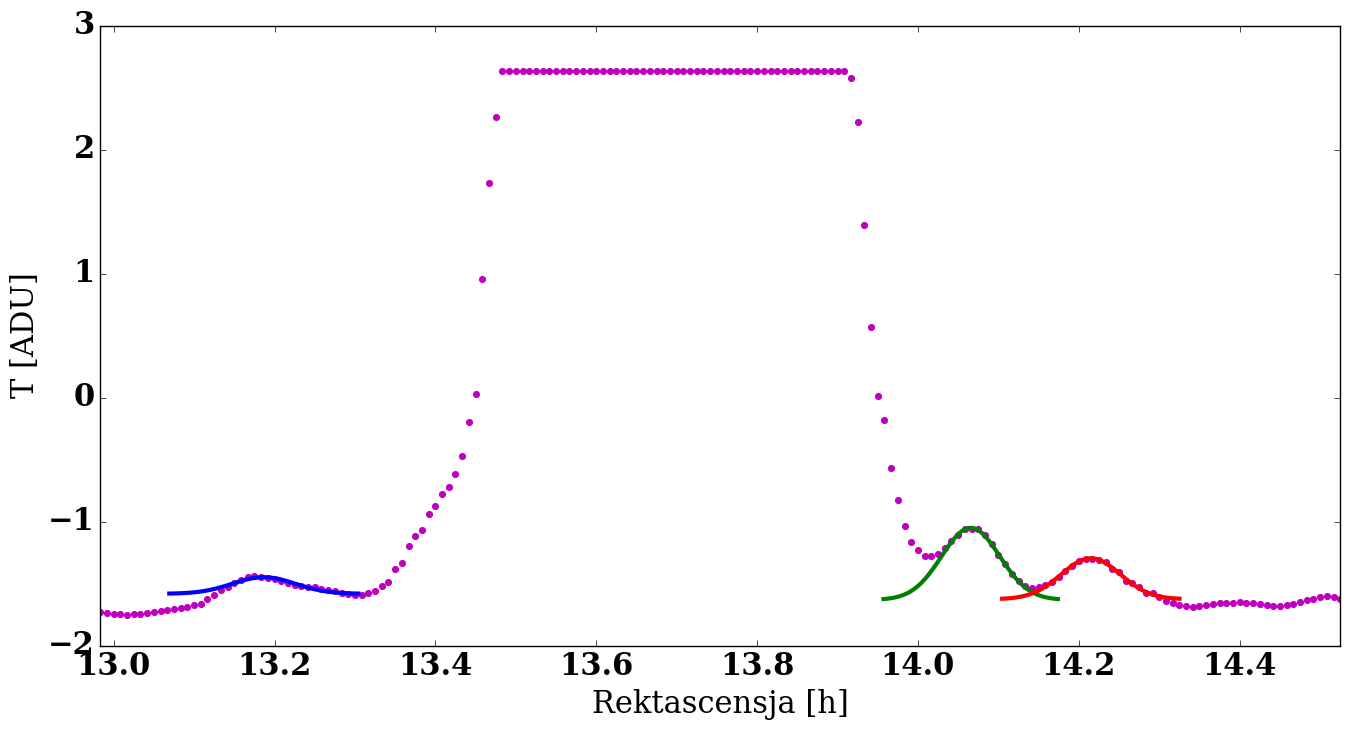

In [103]:
from scipy.optimize import curve_fit

def gauss(x, a, b, sigma, d):
    return a * np.exp(-(x-b)**2/(2*sigma**2)) + d

def fit_gauss(ra_min, ra_max):
    ind = ((ra_min <= mean_ra) & (mean_ra <= ra_max))
    bounds = [(0.01, ra_min, 0, -2), (1, ra_max, 1, -1)]
    fit_params, fit_cov = curve_fit(gauss, mean_ra[ind], mean_sig[ind], bounds = bounds)
    fit_err = np.sqrt(np.diag(fit_cov))
    return fit_params, fit_err


fit_paramsL1, fit_errL1 = fit_gauss(13.13, 13.3)
fit_paramsR1, fit_errR1 = fit_gauss(14.04, 14.13)
fit_paramsR2, fit_errR2 = fit_gauss(14.16, 14.29)

print(fit_paramsL1, fit_errL1)
print(fit_paramsR1, fit_errR1)
print(fit_paramsR2, fit_errR2)

def plot_gauss(fit_params):
    a, b, c, d = fit_params
    args = np.linspace(b-3*c, b+3*c, 100)
    vals = [gauss(x, a, b, c, d) for x in args]
    plt.plot(args, vals, linewidth=3)


plt.figure(figsize=(16, 8))
plt.scatter(mean_ra, mean_sig, s = 17, color='m')
plot_gauss(fit_paramsL1)
plot_gauss(fit_paramsR1)
plot_gauss(fit_paramsR2)
plt.xlim([np.min(mean_ra), np.max(mean_ra)])
plt.xlabel("Rektascensja [h]")
plt.ylabel("T [ADU]")
plt.show()    


Przeliczmy rektascensję na stopnie, a temperaturę na kelwiny. To może przydać się później przy porównywaniu listków z innych pomiarów. Ponadto otrzymana szerokość listka w rektascensji zależy od deklinacji obserwacji. Aby szerokości listków były porównywalne należy je przeliczyć na takie jakie byłyby obserwowane na równiku niebieskim. Obliczeniowo sprowadza się to do dodatkowego czynnika $cos \delta$.

In [104]:
def ra_to_deg(ra):
    return ra/24.0*360.0

def adu_to_k(t_adu, dt_adu, a, da):
    return a*t_adu, abs(t_adu)*da + a*dt_adu

from IPython.display import display, HTML

def df_to_html(df, format = "{:.2f}"):
    styles = [
        dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
        dict(selector="td", props=[("text-align", "center")])
    ]
    html = df.style.set_table_styles(styles).format(format).render()
    return html


df_cols = ['Wysokosc listka [K]', '∆ wys. listka [K]',
            'Srodek listka [°]', '∆ sr. listka [°]',
            'Szerokosc polowkowa [°]', '∆ szer. pol [°]']
df_index = ['L1 ra', 'R1 ra', 'R2 ra']

def beam_data(fit_params, fit_err, a, da, dec):
    from math import cos, pi
    h_adu = fit_params[0]
    h_adu_err = fit_err[0]
    h, h_err = adu_to_k(h_adu, h_adu_err, a, da)
    center, center_err = ra_to_deg(fit_params[1]), ra_to_deg(fit_err[1])
    dev, dev_err = 2.35*ra_to_deg(fit_params[2])*cos(dec*pi/180), 2.35*ra_to_deg(fit_err[2])*cos(dec*pi/180)
    return [h, h_err, center, center_err, dev, dev_err]
    

approx_dec = data[3000][1]
df1 = pd.DataFrame(data=[beam_data(fit_paramsL1, fit_errL1, a, da, approx_dec),
                         beam_data(fit_paramsR1, fit_errR1, a, da, approx_dec),
                         beam_data(fit_paramsR2, fit_errR2, a, da, approx_dec)],
                   columns=df_cols,
                   index=df_index)

HTML(df_to_html(df1))

Dokonamy analogicznej analizy dla skanu w deklinacji. Jednakże skanowanie słońca w deklinacji jest w pewien sposób trudniejsze, ponieważ kąt godzinny słońca ciągle się zmienia. Toteż przy każdym skanie przecinamy słońce wzdłuż trochę innej cięciwy.

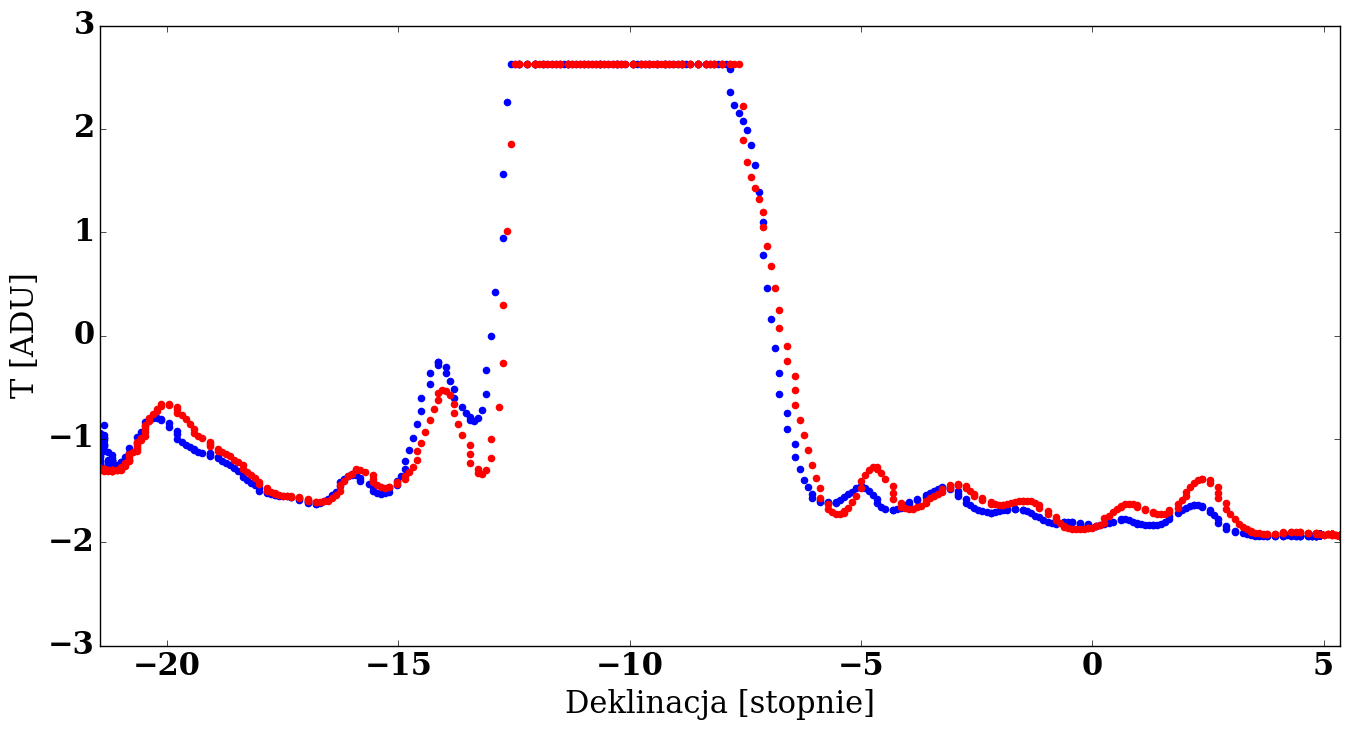

In [105]:
skand1 = data[5400:5900]
skand2 = data[6100:6600]

def plot_data_d(data, c = 'b'):
    sig = [float(d[2]) for d in data]
    dec = [float(d[1]) for d in data]
    plt.scatter(dec, sig, s = 20, color=c)
    plt.xlim([np.min(dec), np.max(dec)])
    plt.xlabel("Deklinacja [stopnie]")
    plt.ylabel("T [ADU]")
    
plt.figure(figsize=(16, 8))
plot_data_d(skand1, 'b')
plot_data_d(skand2, 'r')
plt.show()    


Jak widzimy wyniki z obu przebiegów są podobne, jednak są między nimi też istotne różnice i ich uśrednienie nie miało by większego sensu. Podobnie jak w poprzednim przypadku listki okazują się nie być symetryczne względem środka. 
Do dalszej analizy wybierzemy tylko jeden z przebiegów, ale najpierw przedstawmy przez jaki obszar tarczy słonecznej mniej więcej przebiegał pomiar.

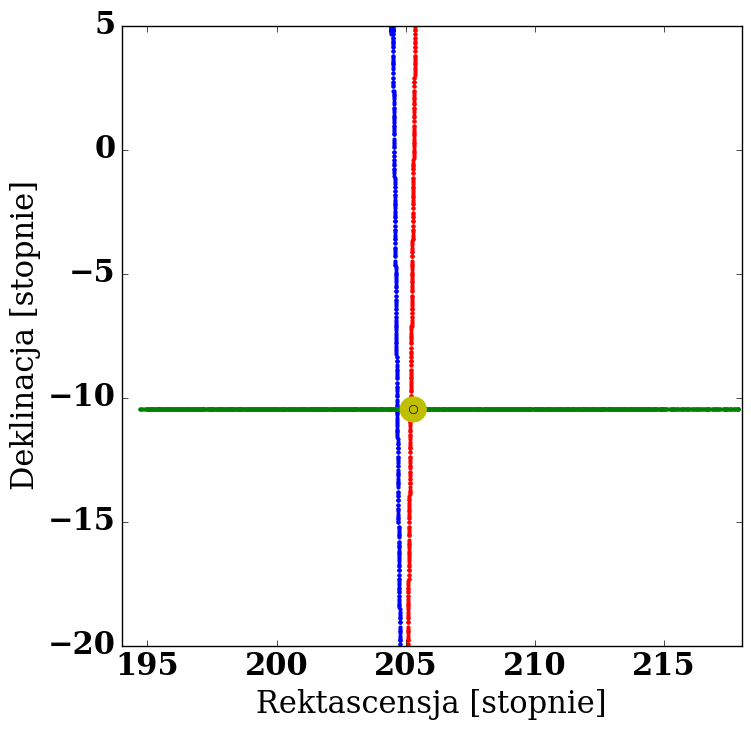

In [106]:
#z efemeryd na godzinę 12:20
ra_sun =  ra_to_deg(13.686167)
dec_sun = -10.479722
visible_sun_radius = 0.5

def get_scan_ra(scan):
    return [ra_to_deg(float(x[0])) for x in scan]

def get_scan_dec(scan):
    return [float(x[1]) for x in scan]

skant1ra, skant1dec = get_scan_ra(skant1), get_scan_dec(skant1)
skant2ra, skant2dec = get_scan_ra(skant2), get_scan_dec(skant2)

skand1ra, skand1dec = get_scan_ra(skand1), get_scan_dec(skand1)
skand2ra, skand2dec = get_scan_ra(skand2), get_scan_dec(skand2)

fig, ax = plt.subplots(figsize=(8, 8))
circ = plt.Circle((ra_sun, dec_sun), radius=visible_sun_radius, color='y', fill=True)

ax.scatter(skand1ra, skand1dec, color='b', s=4)
ax.scatter(skand2ra, skand2dec, color='r', s=4)

ax.scatter(skant1ra, skant1dec, color='m', s=4)
ax.scatter(skant2ra, skant2dec, color='g', s=4)
ax.plot(ra_sun, dec_sun, 'yo')
ax.add_artist(circ)

plt.xlim(194, 218)
plt.ylim(-20, 5)
plt.xlabel("Rektascensja [stopnie]")
plt.ylabel("Deklinacja [stopnie]")

plt.show()    


Na powyższym wykresie przedstawiono cztery wspomniane dotychczas skany (te w kącie godzinnym się pokrywają dlatego widać tylko jeden, zielony, odcinek). Żółtym kółkiem zaczaczono słońce, jego średnica odpowiada w przybliżeniu średnicy słońca w świetle widzialnym. Jak widać niebieski przebieg jest trochę dalszy od środka tarczy słonecznej niż czerwony, dlatego listki wyznaczymy dla tego drugiego pomiaru. Ponadto ograniczymy się tylko do dwóch listków, jednego po prawej i jednego po lewej listka głównego.

[  0.84984584 -14.02711347   0.33951247  -1.38360143] [ 0.07051686  0.0076584   0.02953887  0.07635489]
[ 0.4898611  -4.72972052  0.28926611 -1.75436651] [ 0.01799207  0.01240118  0.02084445  0.01954176]


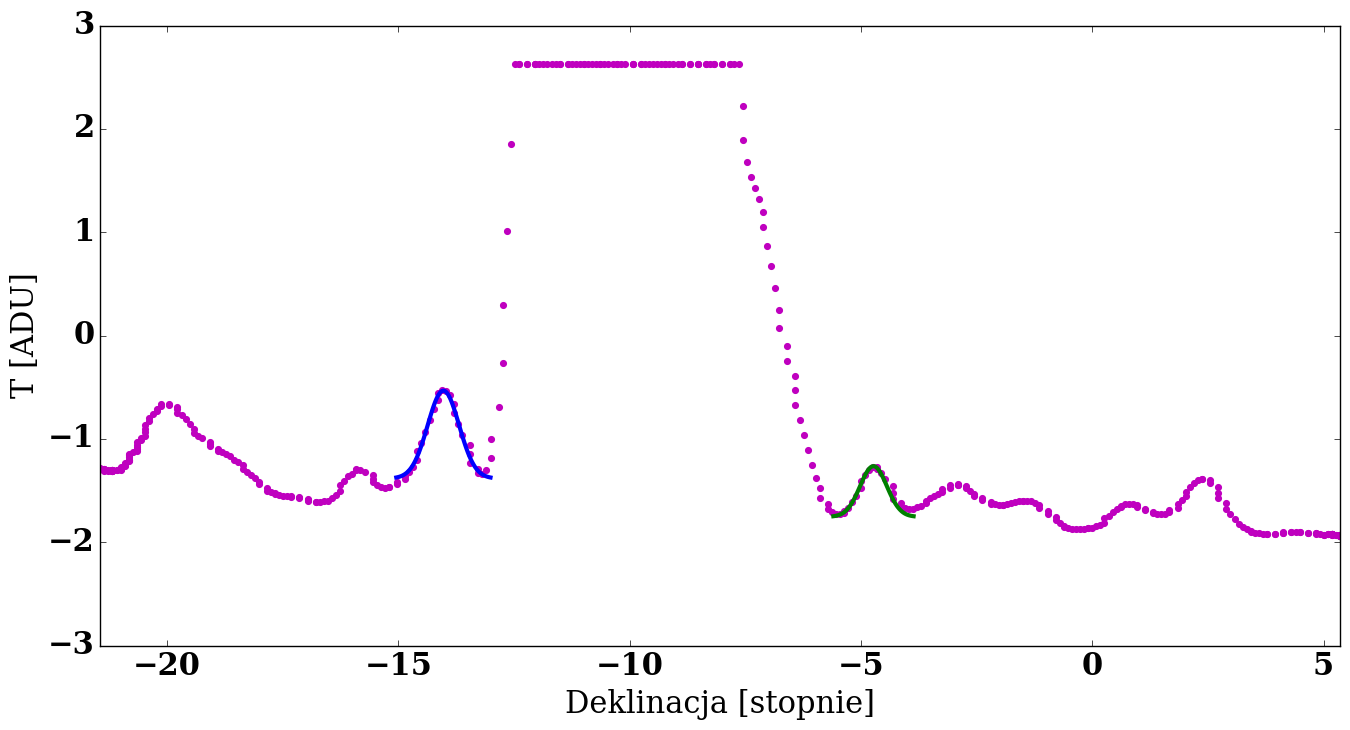

In [107]:
scan = skand2
all_dec = np.array([float(d[1]) for d in scan])
all_sig = np.array([float(d[2]) for d in scan])

def fit_gauss2(dec_min, dec_max):
    ind = ((dec_min <= all_dec) & (all_dec <= dec_max))
    bounds = [(0.01, dec_min, 0, -2), (1, dec_max, 1, 0)]
    fit_params, fit_cov = curve_fit(gauss, all_dec[ind], all_sig[ind], bounds = bounds)
    fit_err = np.sqrt(np.diag(fit_cov))
    return fit_params, fit_err

fit_paramsL1, fit_errL1 = fit_gauss2(-14.7, -13.6)
fit_paramsR1, fit_errR1 = fit_gauss2(-5.5, -4.5)

print(fit_paramsL1, fit_errL1)
print(fit_paramsR1, fit_errR1)

plt.figure(figsize=(16, 8))
plt.scatter(all_dec, all_sig, s = 17, color='m')
plot_gauss(fit_paramsL1)
plot_gauss(fit_paramsR1)
plt.xlim([np.min(all_dec), np.max(all_dec)])
plt.xlabel("Deklinacja [stopnie]")
plt.ylabel("T [ADU]")
plt.show()    

In [108]:
df_cols = ['Wysokosc listka [K]', '∆ wys. listka [K]',
            'Srodek listka [°]', '∆ sr. listka [°]',
            'Szerokosc polowkowa [°]', '∆ szer. pol [°]']
df_index = ['L1 dec', 'R1 dec']

def beam_data_dec(fit_params, fit_err, a, da):
    h_adu = fit_params[0]
    h_adu_err = fit_err[0]
    h, h_err = adu_to_k(h_adu, h_adu_err, a, da)
    center, center_err = fit_params[1], fit_err[1]
    dev, dev_err = 2.35*fit_params[2], 2.35*fit_err[2]
    return [h, h_err, center, center_err, dev, dev_err]
    

df2 = pd.DataFrame(data=[beam_data_dec(fit_paramsL1, fit_errL1, a, da),
                         beam_data_dec(fit_paramsR1, fit_errR1, a, da)],
                   columns=df_cols,
                   index=df_index)

HTML(df_to_html(df2))

Przyjrzyjmy się teraz pomiarom z 20dB i 30dB tłumieniem.

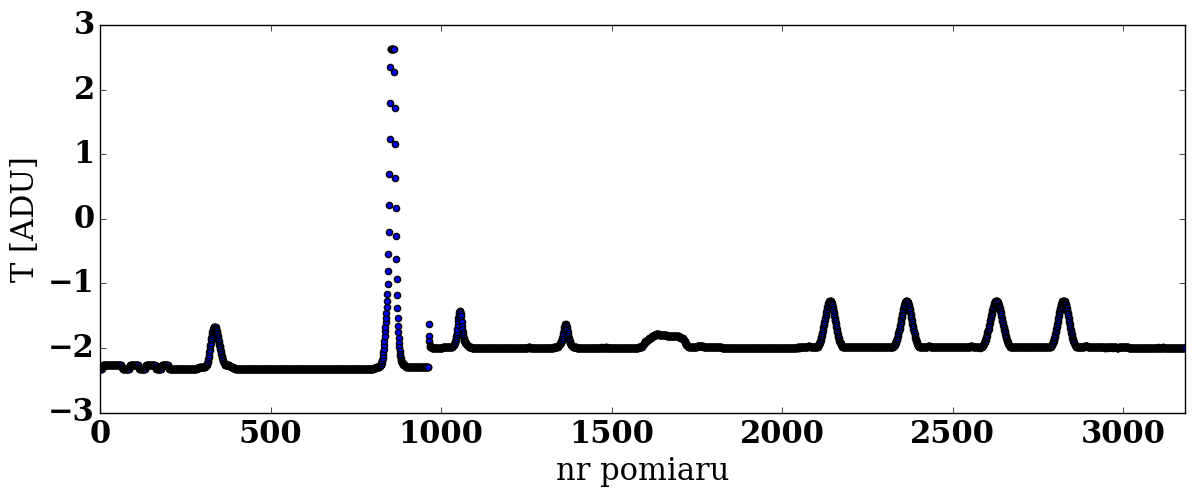

In [109]:
data = load_data('/home/dawid/radioastronomy/2b/LGL2RDEC.TXT')
data_count = len(data)
sig = [d[2] for d in data]
nr = np.arange(data_count)
plt.figure(figsize=(14, 5))
plt.scatter(nr, sig)
plt.xlim([0,data_count])
#plt.xlim(1000,1500)
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()    

Mamy kolejno - kalibrację, prawdopodobnie skan w deklinacji przed korektą kąta godzinnego, nieudaną próbę skanu słońca, przełączenie tłumienia z $20dB$ na $30dB$, dwa skany w deklinacji (różna wysokość świadczy że ponownie przeskanowano wzdłuż trochę innych fragmentów słońca) oraz 4 skany w kącie godzinnym. Ponadto przy $30dB$ także dokonano kalibracji, ale jest ona niewidoczna w tej skali. 

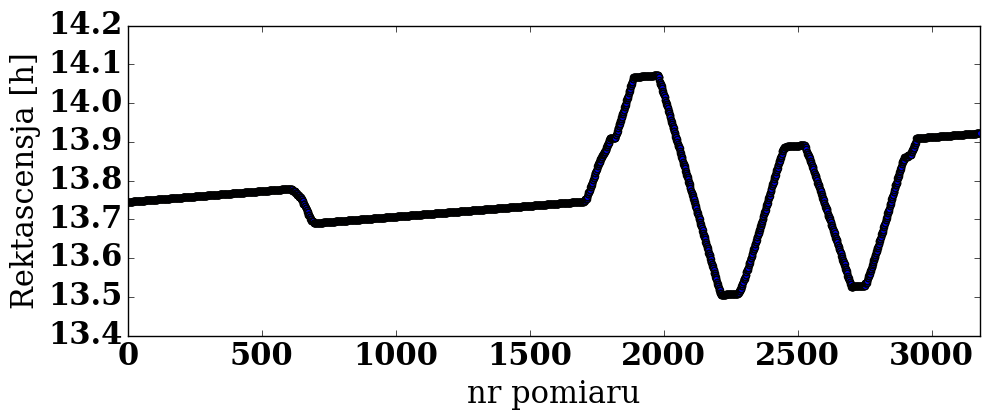

In [110]:
t = np.array([d[0] for d in data])

plt.figure(figsize=(11, 4))
plt.scatter(nr, t)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Rektascensja [h]")
plt.show()  

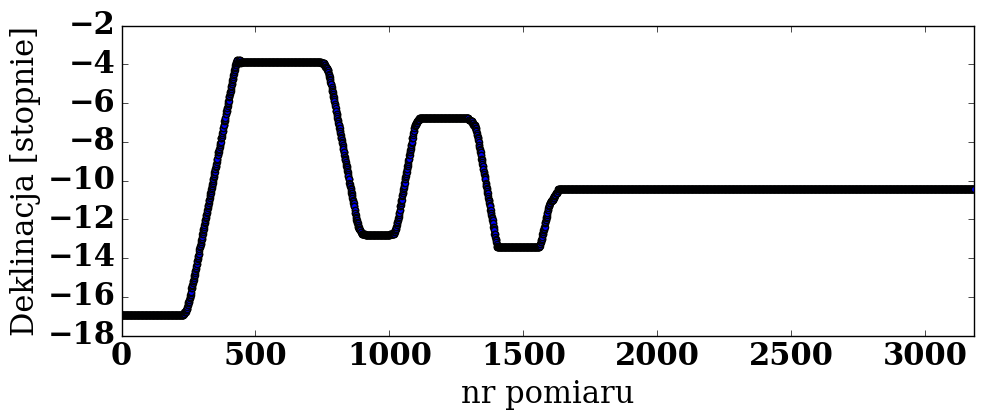

In [111]:
dec = np.array([float(d[1]) for d in data])

plt.figure(figsize=(11, 4))
plt.scatter(nr, dec)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Deklinacja [stopnie]")
plt.show()    

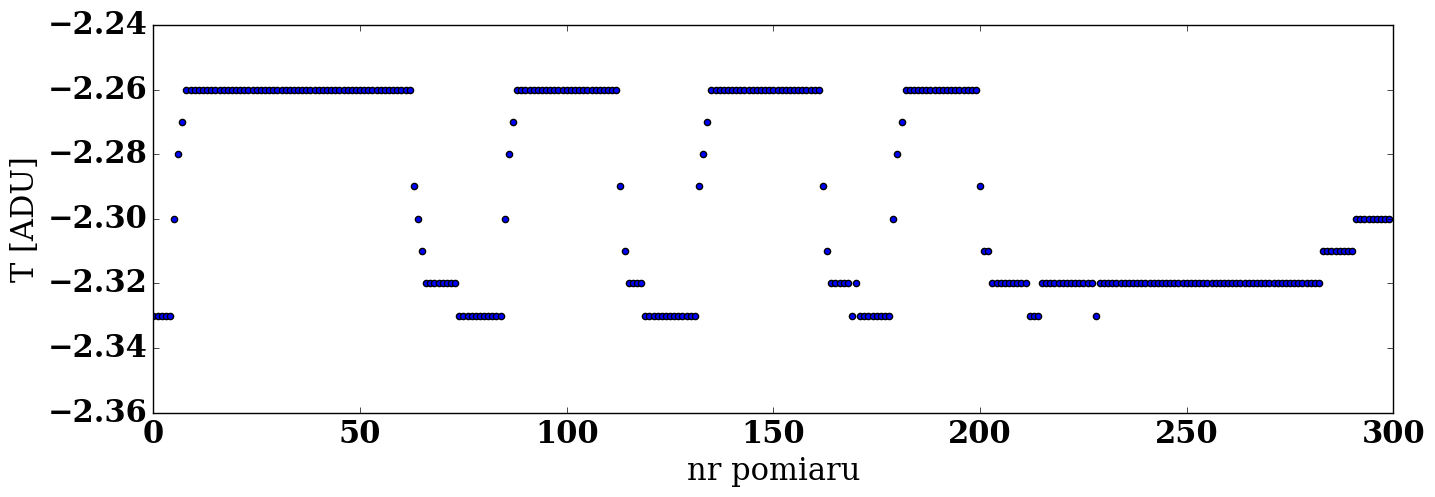

144.793103448 17.0396686364


In [112]:
cal_data = data[:300]
cal_sig_all = [d[2] for d in cal_data]

plt.figure(figsize=(16, 5))
plt.scatter(nr[:300], cal_sig_all)
plt.xlim((0, 300))
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()   

cal_sig = np.concatenate([cal_sig_all[15:60], cal_sig_all[85:110], cal_sig_all[135:160]])
sys_sig = cal_sig_all[210:275]

t_cal = np.mean(cal_sig)
dt_cal = np.std(cal_sig)

t_sys = np.mean(sys_sig)
dt_sys = np.std(sys_sig)

#Z cwiczenia 1a
def a_i(t_cal, t_sys, t_i):
    return t_i * 8670 / (t_cal - t_sys)

def delta_a_i(t_cal, t_sys, dt_cal, dt_sys, t_i):
    return t_i * 8670 * ((dt_sys+dt_cal)/(t_cal - t_sys)/(t_cal - t_sys))

a = a_i(t_cal, t_sys, 0.001)
da = delta_a_i(t_cal, t_sys, dt_cal, dt_sys, 0.001)
print(a, da)

Z kalibracji otrzymujemy przelicznik $$a = 144.8 \pm 17.0 \frac{K}{ADU}$$

Jednakże został on wyznaczony dla tłumienia $20dB$. Ponieważ podczas pomiarów zwiększono tłumienie do $10dB$ więc współczynnik dla późniejszych pomiarów wynosi $$a = 1448 \pm 170 \frac{K}{ADU}$$.

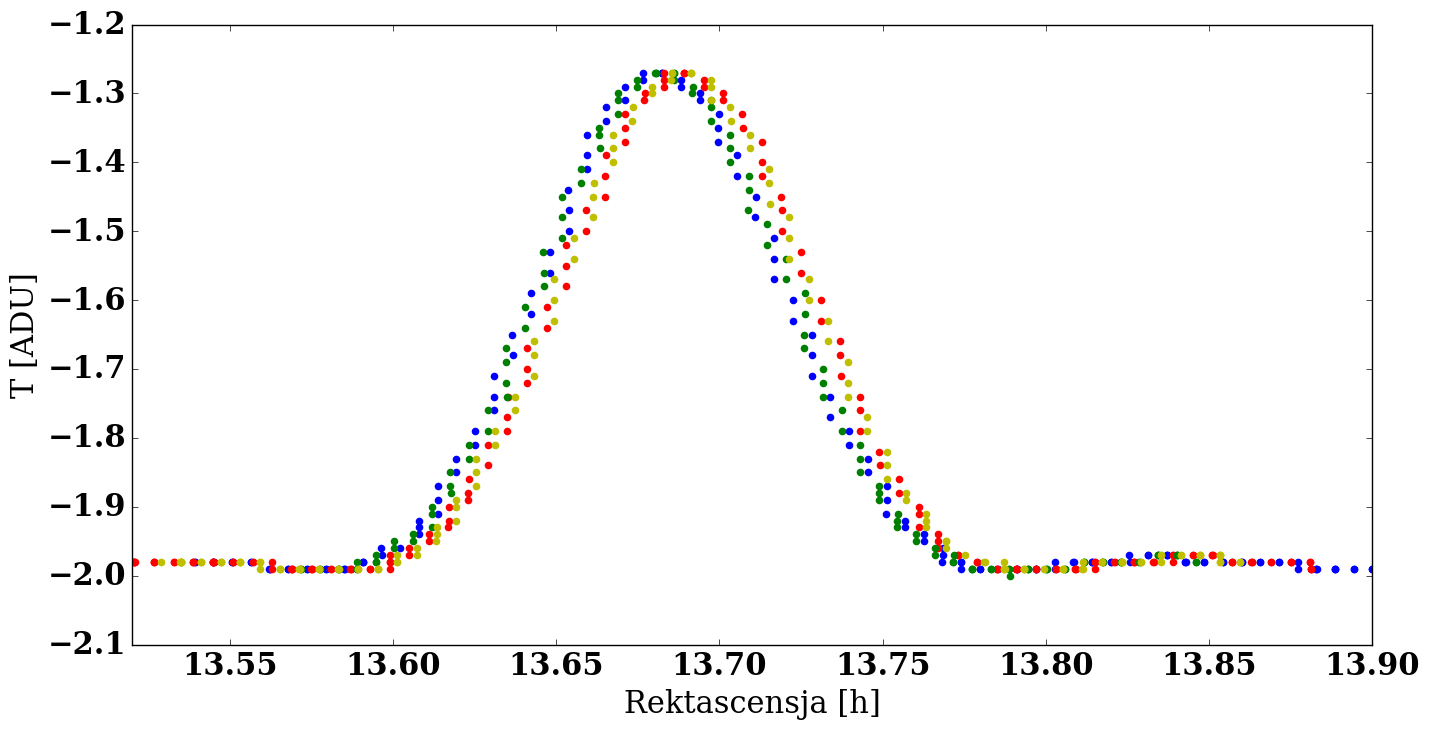

In [113]:
a = 10*a
da = 10*da

skant1 = data[2050:2200]
skant2 = data[2280:2450]
skant3 = data[2550:2680]
skant4 = data[2750:2900]


plt.figure(figsize=(16, 8))
plot_data_t(skant1, 'b')
plot_data_t(skant2, 'r')
plot_data_t(skant3, 'g')
plot_data_t(skant4, 'y')
plt.xlim(13.52, 13.9)

plt.show()    

Dla wszystkich czterech pomiarów wyniki układają się wzdłuż podobnej krzywej Gaussa. Wyraźnie widoczny jest jeden listek, lekkie wahania danych sugerują istnienie listków bocznych. Zauważmy, że niebieskie i zielone punkty występują blisko siebie, podobnie żółte i czerwone. Te pary skanów odpowiadają skanom w tym samym kierunku, co potwierdza hipotezę o wpływie ruchu teleskopu na wynik pomiarów. Uśrednienie skanów pomoże znieść ten efekt.

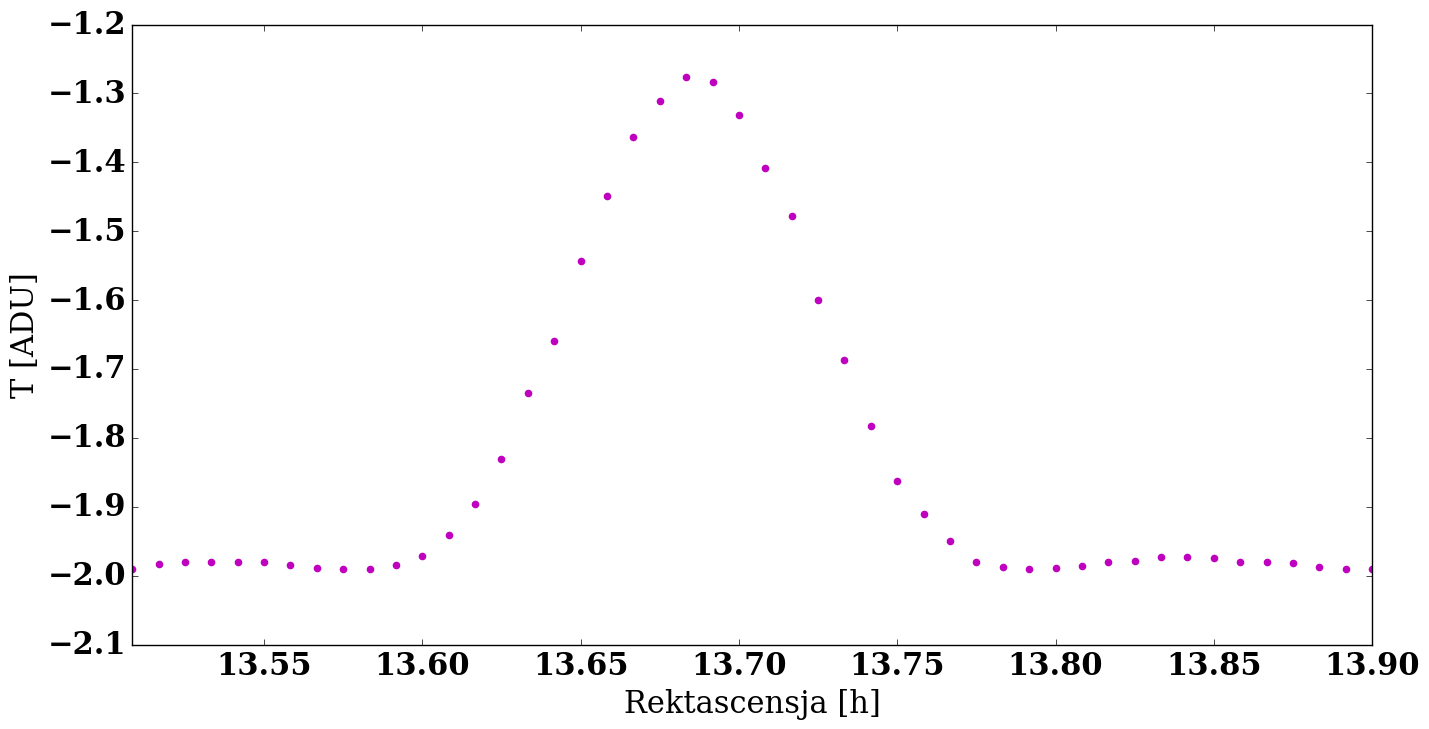

In [114]:
mean_ra, mean_sig, std = calc_mean(group_by_ra(np.concatenate([skant1, skant2, skant3, skant4])))

plt.figure(figsize=(16, 8))
plt.scatter(mean_ra, mean_sig, s = 20, color='m')
plt.xlim([np.min(mean_ra), np.max(mean_ra)])
plt.xlabel("Rektascensja [h]")
plt.ylabel("T [ADU]")
plt.show()    

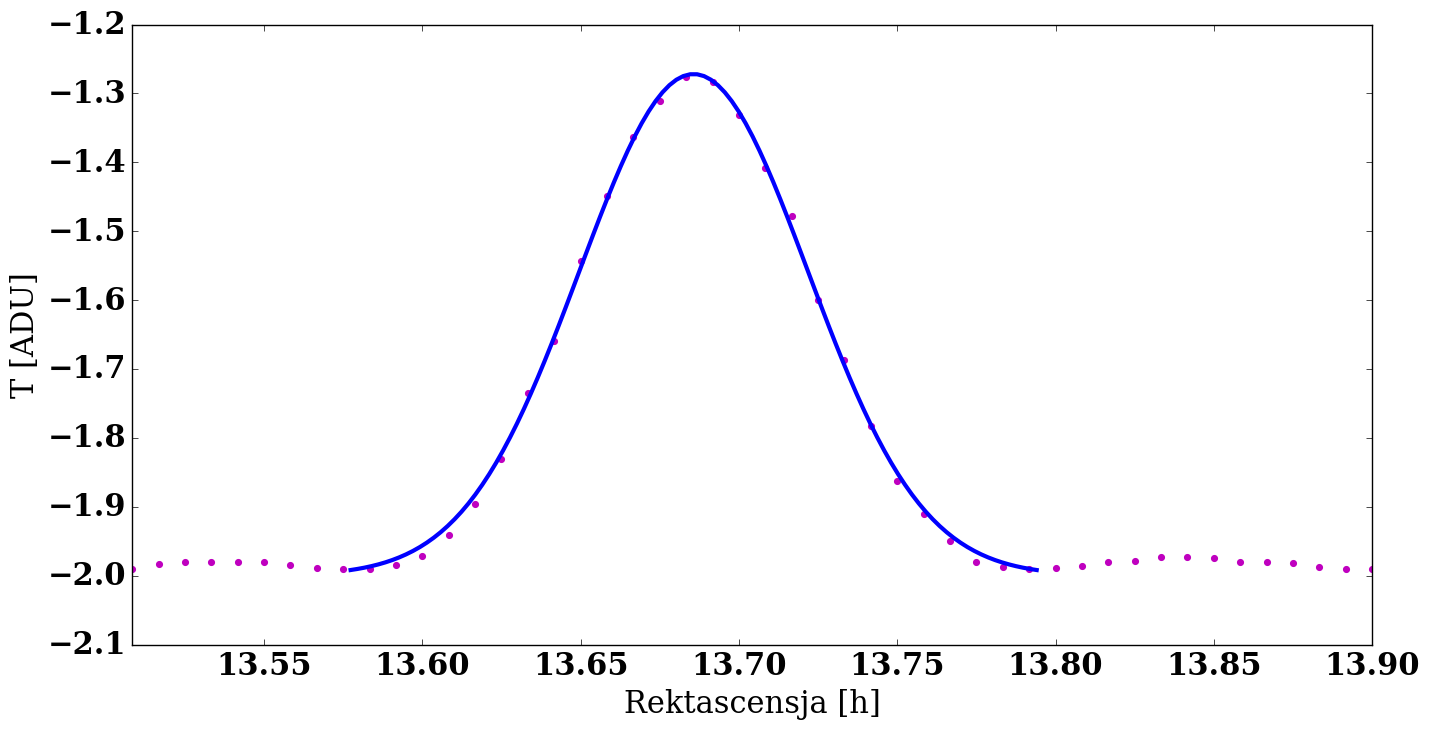

In [115]:
fit_params, fit_err = fit_gauss(13.61, 13.75)

plt.figure(figsize=(16, 8))
plt.scatter(mean_ra, mean_sig, s = 17, color='m')
plot_gauss(fit_params)
plt.xlim([np.min(mean_ra), np.max(mean_ra)])
plt.xlabel("Rektascensja [h]")
plt.ylabel("T [ADU]")
plt.show()    


In [116]:
df_index = ['Main beam ra']

approx_dec = skant1[100][1]
df3 = pd.DataFrame(data=[beam_data(fit_params, fit_err, a, da, approx_dec)],
                   columns=df_cols,
                   index=df_index)

HTML(df_to_html(df3, format = "{:.3f}"))

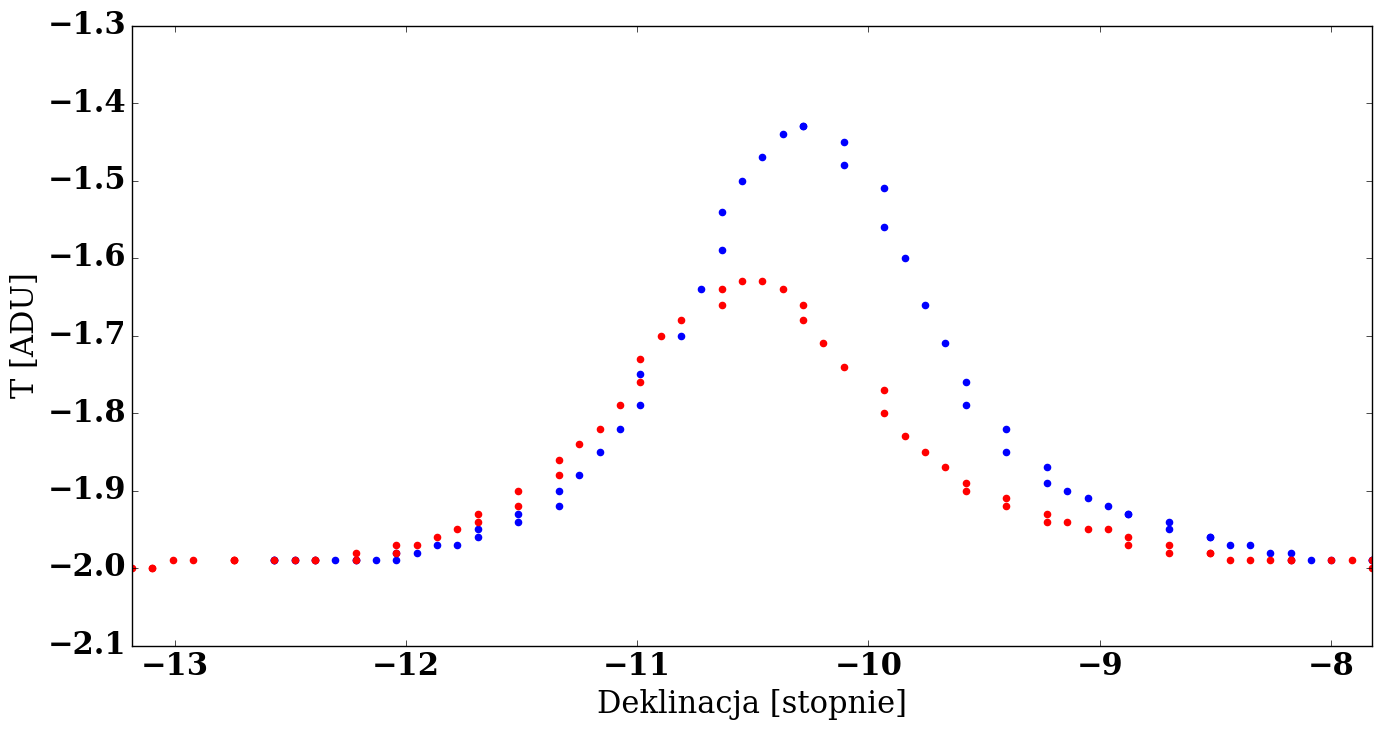

In [117]:
skand1 = data[1020:1100]
skand2 = data[1330:1400]

plt.figure(figsize=(16, 8))
plot_data_d(skand1, 'b')
plot_data_d(skand2, 'r')
plt.show()    

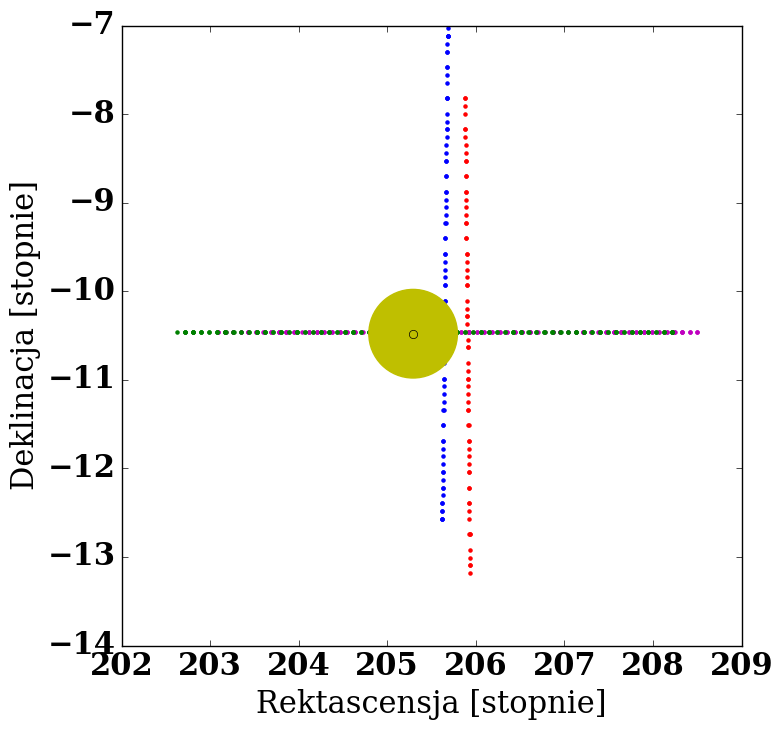

In [118]:
skant1ra, skant1dec = get_scan_ra(skant1), get_scan_dec(skant1)
skant2ra, skant2dec = get_scan_ra(skant2), get_scan_dec(skant2)

skand1ra, skand1dec = get_scan_ra(skand1), get_scan_dec(skand1)
skand2ra, skand2dec = get_scan_ra(skand2), get_scan_dec(skand2)

fig, ax = plt.subplots(figsize=(8, 8))
circ = plt.Circle((ra_sun, dec_sun), radius=visible_sun_radius, color='y', fill=True)

ax.scatter(skand1ra, skand1dec, color='b', s=5)
ax.scatter(skand2ra, skand2dec, color='r', s=5)

ax.scatter(skant1ra, skant1dec, color='m', s=5)
ax.scatter(skant2ra, skant2dec, color='g', s=5)
ax.plot(ra_sun, dec_sun, 'yo')
ax.add_artist(circ)

plt.xlim(202, 209)
plt.ylim(-14, -7)
plt.xlabel("Rektascensja [stopnie]")
plt.ylabel("Deklinacja [stopnie]")

plt.show()    

Analogicznie do wcześniejszego postępowania wybierzemy tylko ten skan bliższy środka słońca.

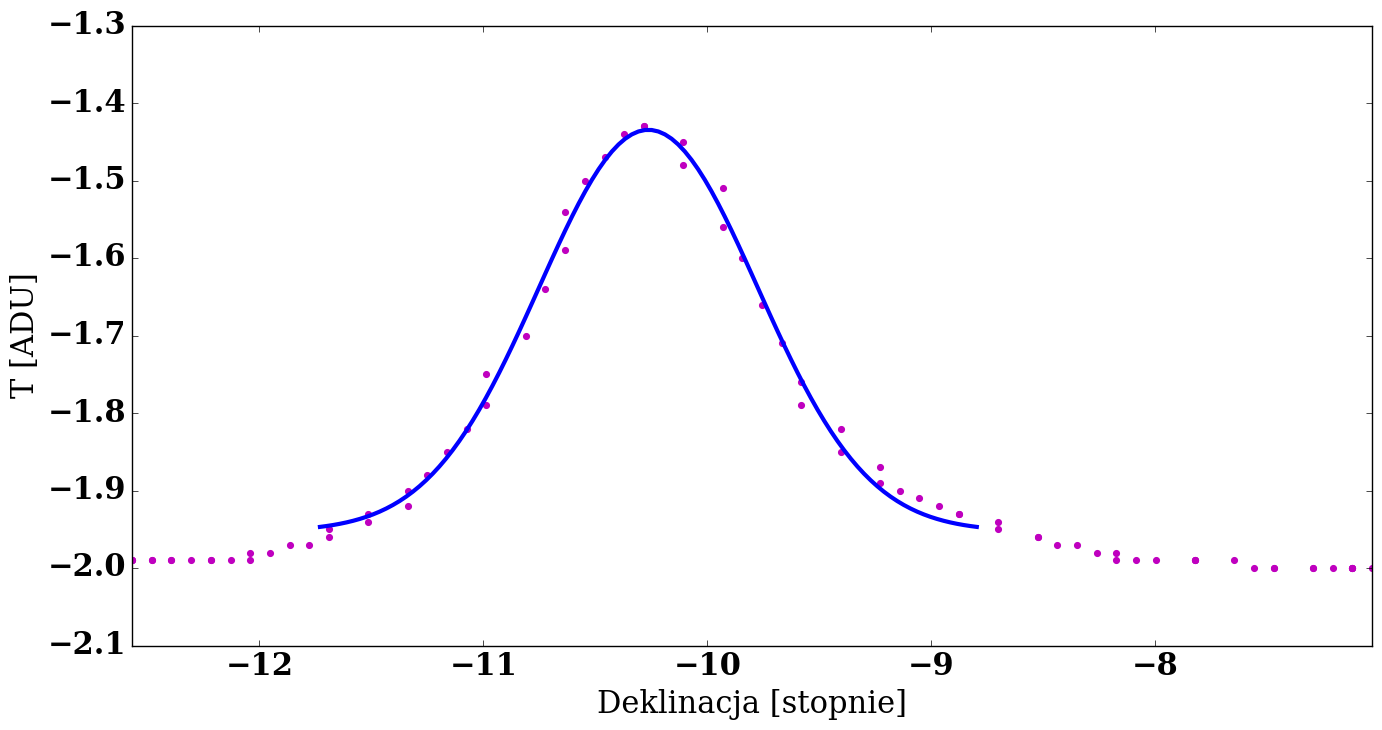

In [119]:
scan = skand1
all_dec = np.array([d[1] for d in scan])
all_sig = np.array([d[2] for d in scan])
fit_params, fit_err = fit_gauss2(-12, -8.8)

plt.figure(figsize=(16, 8))
plt.scatter(all_dec, all_sig, s = 17, color='m')
plot_gauss(fit_params)
plt.xlim([np.min(all_dec), np.max(all_dec)])
plt.xlabel("Deklinacja [stopnie]")
plt.ylabel("T [ADU]")
plt.show()     


In [120]:
df_index = ['Main beam dec']

df4 = pd.DataFrame(data=[beam_data_dec(fit_params, fit_err, a, da)],
                   columns=df_cols,
                   index=df_index)

HTML(df_to_html(df4))

Łącząc wyniki z powyższych pomiarów otrzymujemy:

In [121]:
df = pd.concat([df1, df2, df3, df4])
HTML(df_to_html(df))

Powyższe wyniki pochodzą ze splotu charakterystyki kierunkowej anteny i rozkładu promieniowania źródła. Zakładając pewne uproszczenia (np. że żródło ma charakter jednorodny), można w przybliżeniu wyznaczyć pewne parametry charakterystyki kierunkowej, takie jak różnica poziomów listków (w $dB$) w stosunku do listka głównego.

Różnica poziomów w $dB$ wyraża się wzorem $$d_{l} = -10 log \frac{T_{main}}{T_{l}} ,$$ gdzie $T_{main}$ to otrzymana w ćwiczeniu wysokość listka głównego, a $T_{l}$ wysokość listka bocznego.

Z metody różniczki zupełnej mamy oszacowanie błędu
$$\Delta d_{l} = \frac{10}{ln10}( \frac{\Delta T_{main}}{T_{main}} + \frac{\Delta T_{l}}{T_{l}})$$



In [122]:
from math import log, e

def calc_d(t_main, t_l):
    return -10*log(t_main/t_l, 10)

def calc_delta_d(t_main, dt_main, t_l, dt_l):
    return 10./log(10)*(dt_main/t_main + dt_l/t_l)

h = df[df.columns[0]].values
dh = df[df.columns[1]].values

mra, dmra = h[5], dh[5]
md, dmd = h[6], dh[6]

dra = [calc_d(mra, x) for x in h[0:3]]
ddra = [calc_delta_d(mra, dmra, x, dx) for x, dx in zip(h[0:3], dh[0:3])]

dd = [calc_d(md, x) for x in h[3:5]]
ddd = [calc_delta_d(md, dmd, x, dx) for x, dx in zip(h[3:5], dh[3:5])]

col1 = np.concatenate([dra, dd])
col2 = np.concatenate([ddra, ddd])

dfx = pd.DataFrame()
dfx['Poziom listka wzgledem listka glowego [dB]'] = col1
dfx['Niepewnosc pomiaru [dB]'] = col2
dfx.index = df.index[:5]
HTML(df_to_html(dfx))       

Jak widać w poniższej tabeli poziom listków bocznych jest o dwa rzędy niższy niż listka głównego, co znaczy, że ich wpływ podczas obserwacji silnych radioźródeł jest pomijalny.

### Porównanie z wynikami ćw. 2a

W ćwiczeniu 2a otrzymaliśmy na podstawie obserwacji Cas A następujące szerokości połówkowe
$$FWHM_{dec}^{2a} = 1.05^\circ \pm 0.02^\circ$$
$$FWHM_{ra}^{2a} = 1.22^\circ \pm 0.01^\circ$$
Natomiast w tym ćwiczeniu na podstawie obserwacji Słońca
$$FWHM_{dec}^{2b} = 1.15^\circ \pm 0.03^\circ$$
$$FWHM_{ra}^{2b} = 1.25^\circ \pm 0.03^\circ$$


Na różnicę w deklinacji w obu przypadkach wpływ może mieć trudność wykonania skanu przez środek radioźródła z wykorzystaniem radioteleskopu RT-15. Wiarygodniejsze są wyniki w rektascensji. 

Szerokość połówkowa listka głównego w rektascensji wyszła bardzo zbliżona w obu ćwiczeniach. Sugeruje to, że Słońce (o średnicy około $0.5^\circ$) jest w przybliżeniu źródłem punktowym dla krakowskiego radioteleskopu. 

## Podsumowanie

Udało się wyznaczyć pewne parametry charakterystyki kierunkowej radioteleskopu za pomocą obserwacji Słońca. Wyniki wyglądają na wiarygodne. Ponownie głównym problemem było wykonanie poprawnych skanów w deklinacji. Ciekawym byłoby powtórzenie obserwacji w bezchmurny dzień, aby zweryfikować, czy wpływ chmur rzeczywiście jest znikomy.

